# Deep learning model for a robotic autonomous car
The model comes from fine-tuning MobileNetV2, a light-weight model for image classification.

It was discarded because the overfitting was too high. This can be due, in part, to the high specificity of the task being performed: return a steering angle after looking at lane lines.

## Libraries

In [ ]:
import matplotlib.pyplot as plt
import os

from google.colab import drive
import numpy as np
import pandas as pd

# image handling
from imgaug import augmenters as iaa
from PIL import Image

# machine learning
import tensorflow as tf
from tensorflow import keras
import cv2

print( f'tf.version: {tf.__version__}')

tf.version: 2.15.0


## Dataset creation

In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Mi educación/TFGs/TFG inf/driving-frames'
model_output_dir = ('/content/drive/My Drive/Mi educación/'
                    'TFGs/TFG inf/trained-models')

In [ ]:
"""
Dataset creation
--------
The training set is composed by frames of the driving videos obatined by the
car camera. Each frame is an image whose name contains the steering angle in
which the car had to drive to follow the lane lines and keep itslef in the
circuit. Those angles where computed while driving the car manually with the
method manual_driver of SmartPiCar. The obtained images and its angles where
manually cleaned and corrected to account for some bad entries.

The validation set is composed by frames of different driving videos, including
different circuits. This improved the performance of the model significantly.

For the labels, they come from the names of the images.
  - 90º: keep going straight
  - <90º: turn left
  - >90º: turn right
"""

train_file_names = os.listdir(os.path.join(data_dir,'training'))
train_file_names = sorted(train_file_names)
train_angles = [int(name[-7:-4]) for name in train_file_names]

val_file_names = os.listdir(os.path.join(data_dir,'validation'))
val_file_names = sorted(val_file_names)
val_angles = [int(name[-7:-4]) for name in val_file_names]

print(f'number of images for training: {train_file_names}')
print(f'Number of steering angles for training: {len(train_angles)}')
print(f'number of validation images: {val_file_names}')
print(f'Number of steering angles for validation: {len(val_angles)}')

number of images for training: ['v141738-f000-a090.png', 'v141738-f000i-a090.png', 'v141738-f001-a090.png', 'v141738-f001i-a090.png', 'v141738-f002-a090.png', 'v141738-f002i-a090.png', 'v141738-f004-a090.png', 'v141738-f004i-a090.png', 'v141738-f005-a090.png', 'v141738-f005i-a090.png', 'v141738-f006-a093.png', 'v141738-f006i-a087.png', 'v141738-f007-a093.png', 'v141738-f007i-a087.png', 'v141738-f008-a093.png', 'v141738-f008i-a087.png', 'v141738-f010-a093.png', 'v141738-f010i-a087.png', 'v141738-f011-a093.png', 'v141738-f011i-a087.png', 'v141738-f012-a093.png', 'v141738-f012i-a087.png', 'v141738-f013-a093.png', 'v141738-f013i-a087.png', 'v141738-f014-a093.png', 'v141738-f014i-a087.png', 'v141738-f015-a093.png', 'v141738-f015i-a087.png', 'v141738-f017-a093.png', 'v141738-f017i-a087.png', 'v141738-f018-a093.png', 'v141738-f018i-a087.png', 'v141738-f019-a093.png', 'v141738-f019i-a087.png', 'v141738-f020-a093.png', 'v141738-f020i-a087.png', 'v141738-f021-a093.png', 'v141738-f021i-a087.png',

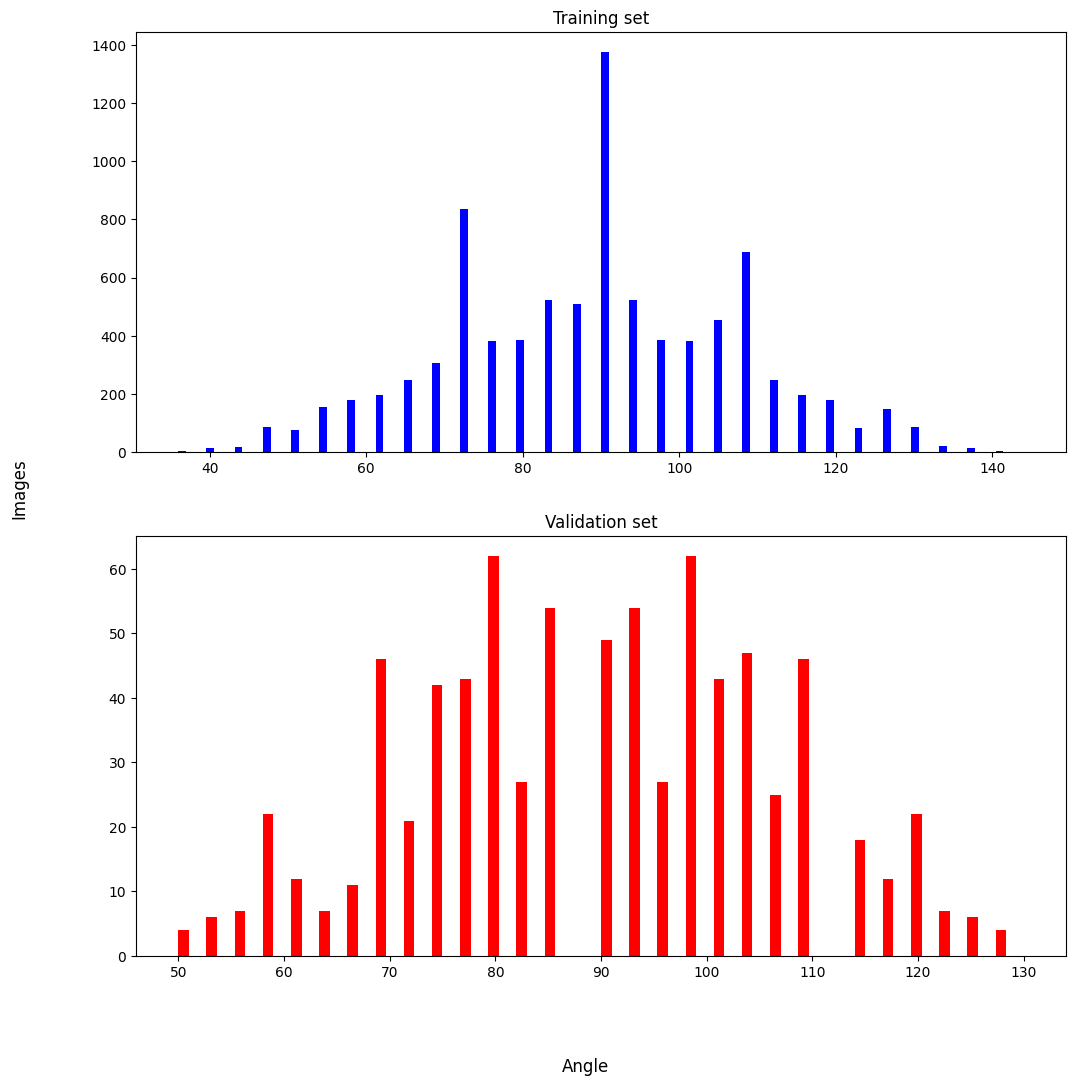

In [ ]:
# Check steering angle distribution for both sets
fig, axes = plt.subplots(2,1, figsize=(12, 12))
axes[0].hist(train_angles, bins=30, width=1, color='blue')
axes[0].set_title('Training set')

axes[1].hist(val_angles, bins=30, width=1, color='red')
axes[1].set_title('Validation set')

fig.supxlabel('Angle')
fig.supylabel('Images')
plt.show()

In [ ]:
# dataset building with keras
train_dataset = keras.utils.image_dataset_from_directory(
    data_dir + '/training',
    labels=train_angles,
    label_mode='int',
    color_mode='rgb',
    batch_size=64,
    image_size=(240,320),
    seed=123)

val_dataset = keras.utils.image_dataset_from_directory(
    data_dir + '/validation',
    labels=val_angles,
    label_mode='int',
    color_mode='rgb',
    batch_size=64,
    image_size=(224,320),
    seed=123)

Found 8695 files belonging to 37 classes.
Found 786 files belonging to 35 classes.


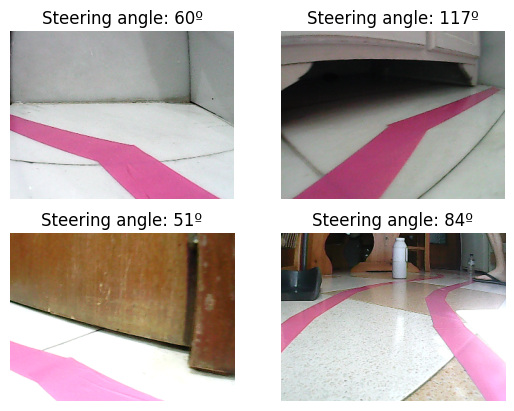

In [ ]:
# check some samples of the training dataset
images = []
while len(images) < 4:
  for images, labels in train_dataset.take(1):
    im_shape = images[1].shape
    for i in range(4):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(f'Steering angle: {labels[i].numpy()}º')
      plt.axis('off')

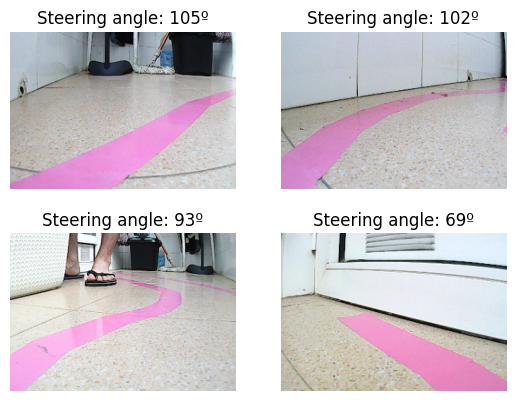

In [ ]:
# check some samples of the validation dataset
images = []
while len(images) < 4:
  for images, labels in val_dataset.take(1):
    im_shape = images[1].shape
    for i in range(4):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(f'Steering angle: {labels[i].numpy()}º')
      plt.axis('off')

## Deep learning model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

print('Layers of MobileNetV2: ', len(base_model.layers))

base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step
Layers of MobileNetV2:  154


In [ ]:
# preprocessing layers
preprocessing_layers = keras.Sequential([
  keras.layers.Cropping2D(cropping=((120,0),(0,0))),
  keras.layers.Resizing(224,224),
  keras.layers.Rescaling(1./127.5,offset=-1)])

In [ ]:
# combine layers and add 2 more layers and the output layer.
model = keras.Sequential([
  preprocessing_layers,
  base_model,
  keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse',
              optimizer='adam')

In [ ]:
model.build((64,240,320,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (64, 5, 5, 32)            368672    
                                                                 
 global_average_pooling2d (  (64, 32)                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (64, 1)                   33        
                                                                 
Total params: 2626689 (10.02 MB)
Trainable params: 368

## Training and results

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir, 'lane-nav-mobilenet2-check.h5'),
                          verbose=1, save_best_only=True)

history = model.fit(train_dataset,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint_callback],
                    validation_data=val_dataset)

In [ ]:
model.save(
    os.path.join(model_output_dir,'lane_navigation_MobileNet2.keras'),
    save_format='keras',)

In [ ]:
# plot learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss[:10], label='Training loss')
ax.plot(val_loss[:10], label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Mean cuadratic error')
plt.title('MobileNet V2')
plt.xlabel('epoch', labelpad=2)
ax.yaxis.tick_right()
plt.show()

## Second training

In [ ]:
"""
After the previous training went wrong, a second training was tried with
the base model layers set as trainable. However, the results were also
disappointing.
"""
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
base_model.trainable = True

fine_tuning_threshold = 100
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-5))

print(len(model.trainable_variables))

58


In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=15,
                         verbose=1,
                         initial_epoch=history.epoch[-1],
                         callbacks=[checkpoint_callback],
                         validation_data=test_dataset)

Epoch 10/15
49/49 [==============================] - ETA: 0s - loss: 1245.5240
Epoch 10: val_loss did not improve from 1068.45740
49/49 [==============================] - 222s 5s/step - loss: 1245.5240 - val_loss: 1292.7770
Epoch 11/15
49/49 [==============================] - ETA: 0s - loss: 978.2178
Epoch 11: val_loss did not improve from 1068.45740
49/49 [==============================] - 222s 4s/step - loss: 978.2178 - val_loss: 1346.6199
Epoch 12/15
49/49 [==============================] - ETA: 0s - loss: 897.9557
Epoch 12: val_loss did not improve from 1068.45740
49/49 [==============================] - 218s 4s/step - loss: 897.9557 - val_loss: 1354.1938
Epoch 13/15
49/49 [==============================] - ETA: 0s - loss: 828.5735
Epoch 13: val_loss did not improve from 1068.45740
49/49 [==============================] - 219s 4s/step - loss: 828.5735 - val_loss: 1359.4701
Epoch 14/15
49/49 [==============================] - ETA: 0s - loss: 766.6420
Epoch 14: val_loss did not impro

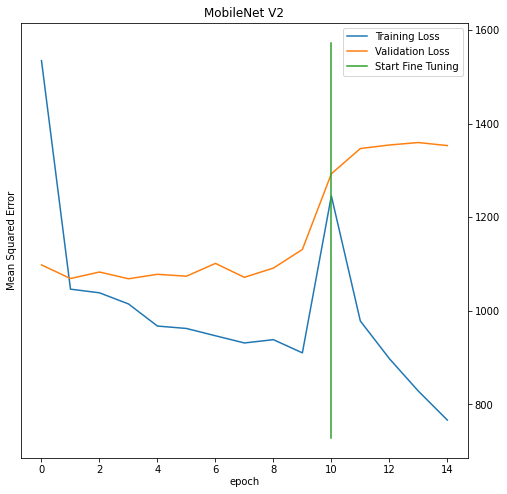

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss[:15], label='Training loss')
ax.plot(val_loss[:15], label='Validation loss')
ax.plot([10,10],
          plt.ylim(), label='Start of adjustment')
plt.legend(loc='upper right')
plt.ylabel('Mean cuadratic error')
plt.title('MobileNet V2')
plt.xlabel('epoch', labelpad=2)
ax.yaxis.tick_right()
plt.show()